## splitting a domain into a tile of stretched grids

Requires all grids to be at level 0. 

Let's build a test set that we will split further:

In [1]:
import numpy as np 

# initial gridding with variable widths
def calc_rescale_grid_dim(wids):
    
    edges = np.cumsum(wids)
    edges = np.concatenate([[edges[0] - wids[0]], edges]) 
    
    edges = edges - edges[0] 
    edges = edges / edges.max() 
    
    cell_centers = (edges[1:] + edges[0:-1]) / 2.
    wids = edges[1:] - edges[0:-1]
            
    return edges, cell_centers, wids

x_e, x_c, x_wids = calc_rescale_grid_dim(np.linspace(0.1, 10, 40))
y_e, y_c, y_wids = calc_rescale_grid_dim(np.linspace(0.1, 10, 80))
z_e, z_c, z_wids = calc_rescale_grid_dim(np.linspace(0.1, 10, 100))
bbox = np.array([[z_e.min(), z_e.max()], [y_e.min(), y_e.max()], [x_e.min(), x_e.max()]])

# assuming data is defined at cell centers
global_shape = (len(z_wids), len(y_wids), len(x_wids))
data = {'density': np.random.random(global_shape)}
data_units = {'density': 'g/cm**3'}
print(global_shape)

(100, 80, 40)


In [2]:
x_c.max()

0.9752475247524752

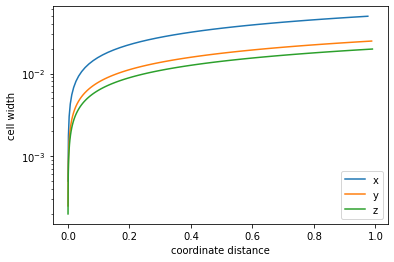

In [3]:
import matplotlib.pyplot as plt 

plt.semilogy(x_c, x_wids, label='x')
plt.semilogy(y_c, y_wids, label='y')
plt.semilogy(z_c, z_wids, label='z')
plt.xlabel('coordinate distance')
plt.ylabel('cell width')
plt.legend()

## stretched grid domain decomposition

splitting by element still makes sense, but we need to correctly calculate edges and store the `cell_widths` appropriately

The function for decomposing, `yt.utilities.decompose.split_array`, assumes uniform spacing:

```python
def split_array(gle, gre, shape, psize):
    """Split array into px*py*pz subarrays."""
    n_d = np.array(shape, dtype=np.int64)
    dds = (gre - gle) / shape
    left_edges = []
    right_edges = []
    shapes = []
    slices = []
    for i in range(psize[0]):
        for j in range(psize[1]):
            for k in range(psize[2]):
                piece = np.array((i, j, k), dtype=np.int64)
                lei = n_d * piece // psize
                rei = n_d * (piece + np.ones(3, dtype=np.int64)) // psize
                lle = gle + lei * dds
                lre = gle + rei * dds
                left_edges.append(lle)
                right_edges.append(lre)
                shapes.append(rei - lei)
                slices.append(np.s_[lei[0] : rei[0], lei[1] : rei[1], lei[2] : rei[2]])

    return left_edges, right_edges, shapes, slices
```

so let's first right this differently... first, it's OK to still use `get_psize` to get the number of grids since this works entirely in index space. So if we want to balance by number of elements in each grid, let's do that:

In [4]:
from yt.utilities.decompose import get_psize 

In [5]:
psize = get_psize(np.array(global_shape), 24)  # 8 subgrids (or "pieces")
print(psize)

[4 3 2]


first, a function to split the array indices, same as `split_array` but only recording the indices of each grid. 

In [6]:
def split_array_indices(shape, psize):
    """Split array into px*py*pz subarrays."""
    n_d = np.array(shape, dtype=np.int64)    
    left_edge_i = []
    right_edge_i = []
    shapes = []
    slices = []
    for i in range(psize[0]):
        for j in range(psize[1]):
            for k in range(psize[2]):
                piece = np.array((i, j, k), dtype=np.int64)
                lei = n_d * piece // psize
                rei = n_d * (piece + np.ones(3, dtype=np.int64)) // psize                
                left_edge_i.append(lei)
                right_edge_i.append(rei)
                shapes.append(rei - lei)
                slices.append(np.s_[lei[0] : rei[0], lei[1] : rei[1], lei[2] : rei[2]])

    return left_edge_i, right_edge_i, shapes, slices

In [7]:
le_i, re_i, shapes, slices = split_array_indices(np.array(global_shape), psize)
print(len(le_i))

24


In [8]:
le_i

[array([0, 0, 0]),
 array([ 0,  0, 20]),
 array([ 0, 26,  0]),
 array([ 0, 26, 20]),
 array([ 0, 53,  0]),
 array([ 0, 53, 20]),
 array([25,  0,  0]),
 array([25,  0, 20]),
 array([25, 26,  0]),
 array([25, 26, 20]),
 array([25, 53,  0]),
 array([25, 53, 20]),
 array([50,  0,  0]),
 array([50,  0, 20]),
 array([50, 26,  0]),
 array([50, 26, 20]),
 array([50, 53,  0]),
 array([50, 53, 20]),
 array([75,  0,  0]),
 array([75,  0, 20]),
 array([75, 26,  0]),
 array([75, 26, 20]),
 array([75, 53,  0]),
 array([75, 53, 20])]

In [9]:
re_i

[array([25, 26, 20]),
 array([25, 26, 40]),
 array([25, 53, 20]),
 array([25, 53, 40]),
 array([25, 80, 20]),
 array([25, 80, 40]),
 array([50, 26, 20]),
 array([50, 26, 40]),
 array([50, 53, 20]),
 array([50, 53, 40]),
 array([50, 80, 20]),
 array([50, 80, 40]),
 array([75, 26, 20]),
 array([75, 26, 40]),
 array([75, 53, 20]),
 array([75, 53, 40]),
 array([75, 80, 20]),
 array([75, 80, 40]),
 array([100,  26,  20]),
 array([100,  26,  40]),
 array([100,  53,  20]),
 array([100,  53,  40]),
 array([100,  80,  20]),
 array([100,  80,  40])]

In [10]:
shapes

[array([25, 26, 20]),
 array([25, 26, 20]),
 array([25, 27, 20]),
 array([25, 27, 20]),
 array([25, 27, 20]),
 array([25, 27, 20]),
 array([25, 26, 20]),
 array([25, 26, 20]),
 array([25, 27, 20]),
 array([25, 27, 20]),
 array([25, 27, 20]),
 array([25, 27, 20]),
 array([25, 26, 20]),
 array([25, 26, 20]),
 array([25, 27, 20]),
 array([25, 27, 20]),
 array([25, 27, 20]),
 array([25, 27, 20]),
 array([25, 26, 20]),
 array([25, 26, 20]),
 array([25, 27, 20]),
 array([25, 27, 20]),
 array([25, 27, 20]),
 array([25, 27, 20])]

so we see the index ranges for each grid. now we need to get the left and right edges of each grid, along with the internal node positions. For a single grid, this would be:

In [11]:
grid_i = 7
grid_data = data['density'][le_i[grid_i][0]:re_i[grid_i][0], 
                            le_i[grid_i][1]:re_i[grid_i][1], 
                            le_i[grid_i][2]:re_i[grid_i][2]]
grid_data.shape

(25, 26, 20)

In [12]:
left_edge = (z_e[le_i[grid_i][0]], y_e[le_i[grid_i][1]], x_e[le_i[grid_i][2]])

In [13]:
left_edge

(0.06435643564356436, 0.0, 0.24866717440974867)

In [14]:
right_edge = (z_e[re_i[grid_i][0]], y_e[re_i[grid_i][1]], x_e[re_i[grid_i][2]])

In [15]:
right_edge

(0.2524752475247525, 0.10724714876550948, 1.0)

In [16]:
z_wids[le_i[grid_i][0]:re_i[grid_i][0]]

array([0.00514851, 0.00534653, 0.00554455, 0.00574257, 0.00594059,
       0.00613861, 0.00633663, 0.00653465, 0.00673267, 0.00693069,
       0.00712871, 0.00732673, 0.00752475, 0.00772277, 0.00792079,
       0.00811881, 0.00831683, 0.00851485, 0.00871287, 0.00891089,
       0.00910891, 0.00930693, 0.00950495, 0.00970297, 0.00990099])

In [17]:
y_wids[le_i[grid_i][1]:re_i[grid_i][1]]

array([0.00024752, 0.00055771, 0.0008679 , 0.00117809, 0.00148828,
       0.00179847, 0.00210866, 0.00241885, 0.00272904, 0.00303923,
       0.00334942, 0.00365961, 0.0039698 , 0.00427998, 0.00459017,
       0.00490036, 0.00521055, 0.00552074, 0.00583093, 0.00614112,
       0.00645131, 0.0067615 , 0.00707169, 0.00738188, 0.00769207,
       0.00800226])

In [18]:
x_wids[le_i[grid_i][2]:re_i[grid_i][2]]

array([0.02562833, 0.026885  , 0.02814166, 0.02939832, 0.03065499,
       0.03191165, 0.03316832, 0.03442498, 0.03568165, 0.03693831,
       0.03819497, 0.03945164, 0.0407083 , 0.04196497, 0.04322163,
       0.04447829, 0.04573496, 0.04699162, 0.04824829, 0.04950495])

so let's wrap that into its own function that builds a list of grids:

In [19]:
def build_grids(data,
                data_units,
                x_e, y_e, z_e,
                x_wids, y_wids, z_wids,
                le_i, re_i, shapes, slices):

    grids = []
    ngrids = len(le_i)
    for igrid in range(ngrids):
        new_grid = {}
        for field in data.keys():
            new_grid[field] = (data[field][le_i[igrid][0]:re_i[igrid][0], 
                                           le_i[igrid][1]:re_i[igrid][1], 
                                           le_i[igrid][2]:re_i[igrid][2]], data_units[field])
        left_edge  = (z_e[le_i[igrid][0]], y_e[le_i[igrid][1]], x_e[le_i[igrid][2]])
        right_edge = (z_e[re_i[igrid][0]], y_e[re_i[igrid][1]], x_e[re_i[igrid][2]])
        cell_widths = [z_wids[le_i[igrid][0]:re_i[igrid][0]],
                       y_wids[le_i[igrid][1]:re_i[igrid][1]],
                       x_wids[le_i[igrid][2]:re_i[igrid][2]]]
                
        new_grid["left_edge"] = left_edge
        new_grid["right_edge"] = right_edge
        new_grid["cell_widths"] = cell_widths
        new_grid["level"] = 0
        new_grid["dimensions"] = shapes[igrid]        
    
        grids.append(new_grid)
    return grids 

In [20]:
grids = build_grids(data, data_units, x_e, y_e, z_e, x_wids, y_wids, z_wids, le_i, re_i, shapes, slices)
grids[0]

{'density': (array([[[0.2364921 , 0.55384563, 0.59658831, ..., 0.65497143,
           0.76792213, 0.67179862],
          [0.51894287, 0.53292262, 0.33427634, ..., 0.39843557,
           0.94222718, 0.90472772],
          [0.82490079, 0.78362259, 0.11704098, ..., 0.27201083,
           0.68364714, 0.74075005],
          ...,
          [0.65983827, 0.88235087, 0.66102556, ..., 0.66402005,
           0.05182433, 0.44954653],
          [0.49011077, 0.25301963, 0.29558627, ..., 0.90788772,
           0.12169252, 0.63203403],
          [0.9219838 , 0.20221487, 0.61358546, ..., 0.65414412,
           0.22705707, 0.63283159]],
  
         [[0.56514531, 0.63974814, 0.65846427, ..., 0.93103111,
           0.56556608, 0.37851896],
          [0.18759554, 0.034621  , 0.53296882, ..., 0.41663943,
           0.08430728, 0.76996804],
          [0.31458273, 0.07335883, 0.71739191, ..., 0.30564274,
           0.65019822, 0.27744198],
          ...,
          [0.04616871, 0.85438465, 0.31562786, ..., 0.9

Now, need to manually build the stream frontend since `load_uniform_grids` and `load_amr_grids` are not quite right for this... most of `load_amr_grids` does work, just need to pull out `cell_widths` as we loop over the grids:

In [21]:
def load_stretched_grids(grid_data, 
                         domain_dimensions,                                                                            
                         bbox=None,                          
                         length_unit = None,
                         mass_unit = None,
                         time_unit = None,
                         velocity_unit = None,
                         magnetic_unit = None,
                         sim_time=0.0,   
                         periodicity=(True, True, True),
                         geometry="cartesian",    
                         unit_system="cgs",
                         default_species_fields=None,
                         *,
                         parameters=None,
                         ):
    
    from yt.frontends.stream.data_structures import (
        StreamDataset,
        StreamDictFieldHandler,
        StreamHandler,
    )
    from yt.frontends.stream.definitions import process_data, set_particle_types
    from yt.utilities.lib.misc_utilities import get_box_grids_level

    domain_dimensions = np.array(domain_dimensions)
    ngrids = len(grid_data)
    if bbox is None:
        bbox = np.array([[0.0, 1.0], [0.0, 1.0], [0.0, 1.0]], "float64")
    domain_left_edge = np.array(bbox[:, 0], "float64")
    domain_right_edge = np.array(bbox[:, 1], "float64")
    grid_levels = np.zeros((ngrids, 1), dtype="int32")
    grid_left_edges = np.zeros((ngrids, 3), dtype="float64")
    grid_right_edges = np.zeros((ngrids, 3), dtype="float64")
    cell_widths = []
    grid_dimensions = np.zeros((ngrids, 3), dtype="int32")
    number_of_particles = np.zeros((ngrids, 1), dtype="int64")
    parent_ids = np.zeros(ngrids, dtype="int64") - 1
    sfh = StreamDictFieldHandler()
    for i, g in enumerate(grid_data):
        grid_left_edges[i, :] = g.pop("left_edge")
        grid_right_edges[i, :] = g.pop("right_edge")
        grid_dimensions[i, :] = g.pop("dimensions")
        grid_levels[i, :] = g.pop("level")
        cell_widths.append(g.pop("cell_widths"))
        if any(grid_levels[i,:]) > 0:
            raise NotImplementedError("cannot have tiled stretched grids with refinement level > 0")
        field_units, data, n_particles = process_data(
            g, grid_dims=tuple(grid_dimensions[i, :])
        )
        number_of_particles[i, :] = n_particles
        sfh[i] = data

    # We now reconstruct our parent ids, so that our particle assignment can
    # proceed.
    mask = np.empty(ngrids, dtype="int32")
    for gi in range(ngrids):
        get_box_grids_level(
            grid_left_edges[gi, :],
            grid_right_edges[gi, :],
            grid_levels[gi] + 1,
            grid_left_edges,
            grid_right_edges,
            grid_levels,
            mask,
        )
        ids = np.where(mask.astype("bool"))
        for ci in ids:
            parent_ids[ci] = gi

    # commenting the following because this function can only use level 0
    # # Check if the grid structure is properly aligned (bug #1295) 
    # for lvl in range(grid_levels.min() + 1, grid_levels.max() + 1):
    #     idx = grid_levels.flatten() == lvl
    #     dims = domain_dimensions * refine_by ** (lvl - 1)
    #     for iax, ax in enumerate("xyz"):
    #         cell_edges = np.linspace(
    #             domain_left_edge[iax], domain_right_edge[iax], dims[iax], endpoint=False
    #         )
    #         if set(grid_left_edges[idx, iax]) - set(cell_edges):
    #             raise YTIllDefinedAMR(lvl, ax)

    
    if length_unit is None:
        length_unit = "code_length"
    if mass_unit is None:
        mass_unit = "code_mass"
    if time_unit is None:
        time_unit = "code_time"
    if velocity_unit is None:
        velocity_unit = "code_velocity"
    if magnetic_unit is None:
        magnetic_unit = "code_magnetic"

    particle_types = {}

    for grid in sfh.values():
        particle_types.update(set_particle_types(grid))

    handler = StreamHandler(
        grid_left_edges,
        grid_right_edges,
        grid_dimensions,
        grid_levels,
        parent_ids,
        number_of_particles,
        np.zeros(ngrids).reshape((ngrids, 1)),
        sfh,
        field_units,
        (length_unit, mass_unit, time_unit, velocity_unit, magnetic_unit),
        particle_types=particle_types,
        periodicity=periodicity,
        parameters=parameters,
        cell_widths = cell_widths, 
    )

    handler.name = "AMRGridData"
    handler.domain_left_edge = domain_left_edge
    handler.domain_right_edge = domain_right_edge
    handler.refine_by = 2  # only level 0 allowed, this will not be used.
    if np.all(domain_dimensions[1:] == 1):
        dimensionality = 1
    elif domain_dimensions[2] == 1:
        dimensionality = 2
    else:
        dimensionality = 3
    handler.dimensionality = dimensionality
    handler.domain_dimensions = domain_dimensions
    handler.simulation_time = sim_time
    handler.cosmology_simulation = 0

    sds = StreamDataset(
        handler,
        geometry=geometry,
        unit_system=unit_system,
        default_species_fields=default_species_fields,
    )
    return sds
    
    
    

In [22]:
grids = build_grids(data, data_units, x_e, y_e, z_e, x_wids, y_wids, z_wids, le_i, re_i, shapes, slices)

ds = load_stretched_grids(grids, 
                          global_shape, 
                          geometry=('cartesian', 'zyx'))

yt : [INFO     ] 2022-09-14 13:15:20,146 Parameters: current_time              = 0.0
yt : [INFO     ] 2022-09-14 13:15:20,147 Parameters: domain_dimensions         = [100  80  40]
yt : [INFO     ] 2022-09-14 13:15:20,147 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-09-14 13:15:20,148 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-09-14 13:15:20,148 Parameters: cosmological_simulation   = 0


In [23]:
ds.index

yt : [INFO     ] 2022-09-14 13:15:20,271 xlim = 0.000000 1.000000
yt : [INFO     ] 2022-09-14 13:15:20,271 ylim = 0.000000 1.000000
yt : [INFO     ] 2022-09-14 13:15:20,272 xlim = 0.000000 1.000000
yt : [INFO     ] 2022-09-14 13:15:20,272 ylim = 0.000000 1.000000
yt : [INFO     ] 2022-09-14 13:15:20,275 Making a fixed resolution buffer of (('stream', 'density')) 800 by 800



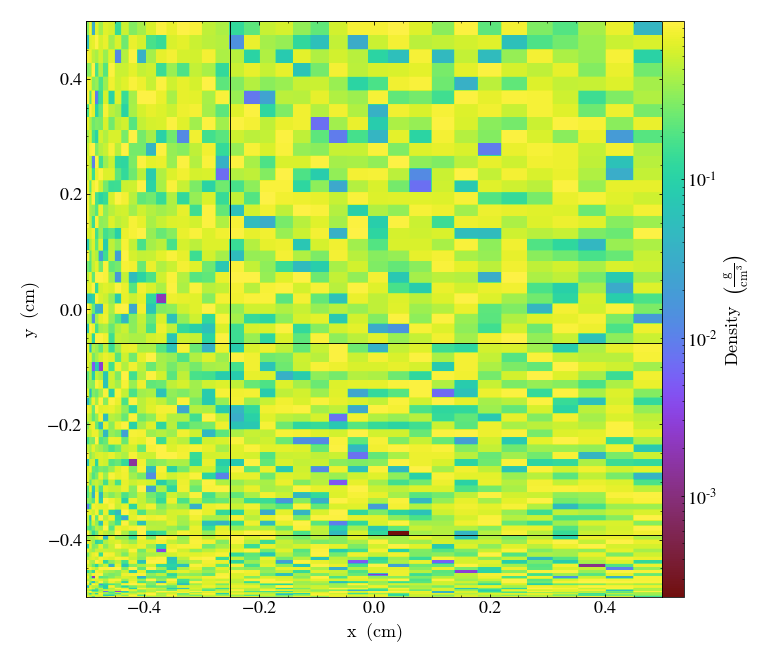

In [24]:
import yt
slc = yt.SlicePlot(ds, "z", ("stream", "density"))
slc.annotate_grids(edgecolors='k')
slc

yt : [INFO     ] 2022-09-14 13:15:20,822 xlim = 0.000000 1.000000
yt : [INFO     ] 2022-09-14 13:15:20,823 ylim = 0.000000 1.000000
yt : [INFO     ] 2022-09-14 13:15:20,824 xlim = 0.000000 1.000000
yt : [INFO     ] 2022-09-14 13:15:20,824 ylim = 0.000000 1.000000
yt : [INFO     ] 2022-09-14 13:15:20,826 Making a fixed resolution buffer of (('stream', 'density')) 800 by 800



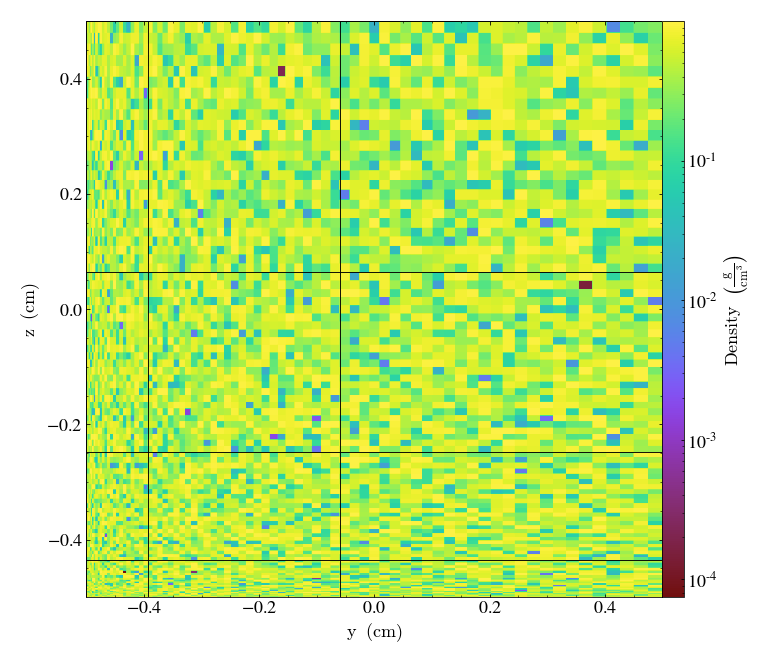

In [25]:
slc = yt.SlicePlot(ds, "x", ("stream", "density"))
slc.annotate_grids(edgecolors='k')
slc

yt : [INFO     ] 2022-09-14 13:15:21,181 xlim = 0.000000 1.000000
yt : [INFO     ] 2022-09-14 13:15:21,182 ylim = 0.000000 1.000000
yt : [INFO     ] 2022-09-14 13:15:21,182 xlim = 0.000000 1.000000
yt : [INFO     ] 2022-09-14 13:15:21,182 ylim = 0.000000 1.000000
yt : [INFO     ] 2022-09-14 13:15:21,184 Making a fixed resolution buffer of (('stream', 'density')) 800 by 800



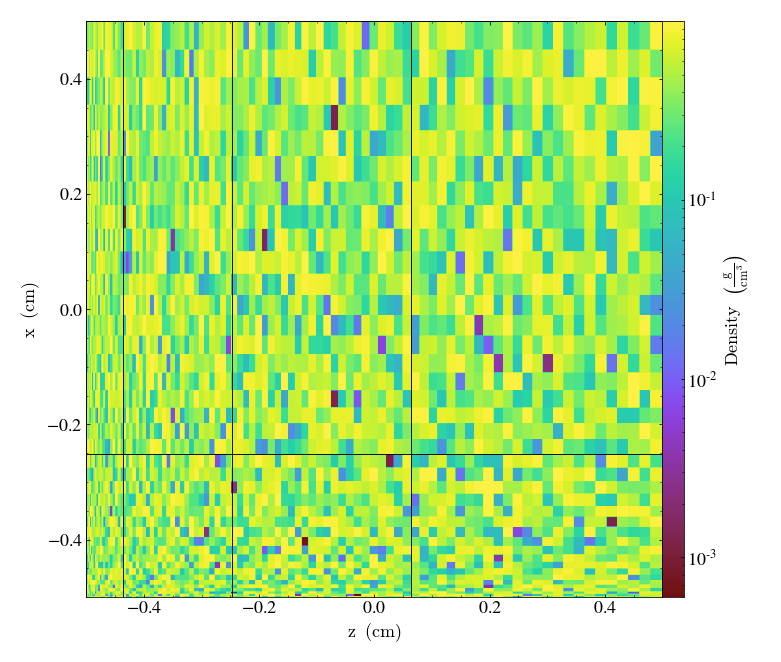

In [26]:
slc = yt.SlicePlot(ds, "y", ("stream", "density"))
slc.annotate_grids(edgecolors='k')
slc